# Recurrent Neural Networks
This assignment aims to implement a simple LSTM from scratch using PyTorch.

Designed by Kien Nguyen Oct 2022.

This part will focus on RNN. In this part, you will learn how to prepare the data, define the model, train and test your model. In this part, you are asked to finish several tasks and report your results. Similar to CNN, you can also use Google Colab.

**Overview:**
- Implement a 1-layer LSTM from scratch using PyTorch
- Train and test the model on the provided dataset
- Implement the built-in 1-layer LSTM and conduct the training pipeline
- Implement the built-in 1-layer GRU and conduct the training pipeline
- Compare the three models implemented

## 1 - Import Python Packages

Run the following cell to import necessary packages for this part.

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F

import os

import time


## 2 - Data Processing [5 points]

The following code will load the raw data stored in the specified ``csv`` file and inspect the overall data format. The machine learning task for this assignment is predicting stock's closing price of the next day given the prices from the previous. Therefore, our input should be a sequence of closing prices of the stock, and the output is the closing price of the next day.

In [246]:
filepath = 'AMZN_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(os.path.join('data', filepath))
data = data.sort_values('Date')
data.head()


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


Plot the raw data.

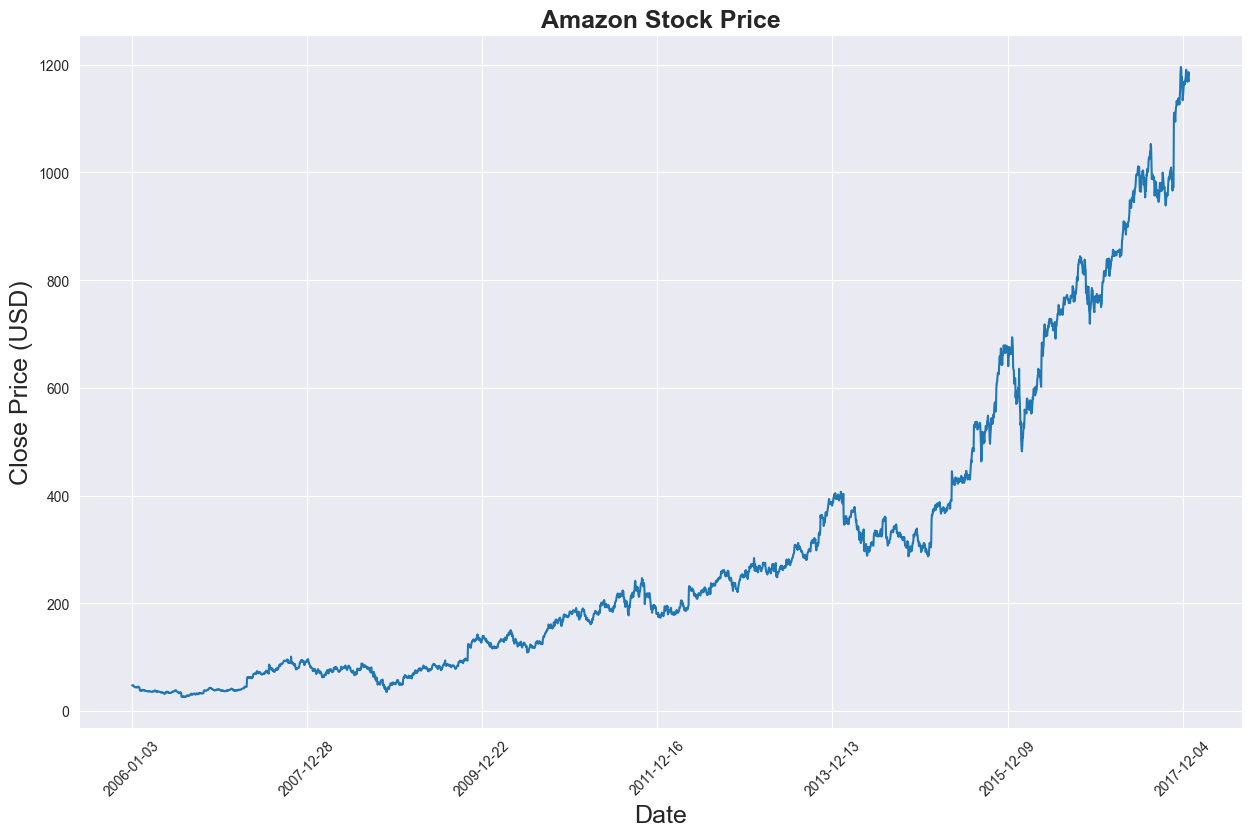

In [247]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()


For this assignment, we focus on the closing price, so we extract the ``Close`` column in the data frame as our data.

In [248]:
price = data[['Close']]
price.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB


Then, we normalize the raw data into the range of ``[-1, 1]``.

In [249]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


/var/folders/sc/wpsymmnn3tj5p4c_qkdvspc80000gn/T/ipykernel_18697/3221609643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


The following method helps process the raw data into the desired input and output formats, and at the same time splits the train and test data.

In [250]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


Call the ``split_data`` function to retrieve ``x_train``, ``y_train``, ``x_test`` and ``y_test``.

In [273]:
# process the raw data
lookback = 20 # choose sequence length
#### START CODE HERE (~1 line) ####
x_train, y_train, x_test, y_test = split_data(price, lookback)
#### END CODE HERE ####
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


Convert from ``numpy.array`` to ``torch.tensor``.

In [274]:
# Convert to torch Tensor
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


Here provides the hyper-parameters for the assignment. You can try changing these hyper-parameters and observe the difference in the model's performance.

In [253]:
# hyper-parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 100
learning_rate = 0.01


## 3 - Define the Model [25 points]

Next, we will implement an LSTM cell using only PyTorch's ``torch.nn.Linear`` layer and some appropriate activation functions. Below is the formula of now to calculate different gates, the hidden state and the cell state for timestep ``t`` given the hidden state and the cell state from ``t-1`` and the input from ``t``. You can also refer to the official PyTorch's documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) for more details.

Input gate: $i_t = \sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})$

Forget gate: $f_t = \sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf})$

Cell gate: $g_t = \text{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})$

Output gate: $o_t = \sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho})$

Cell state: $c_t = f_t \odot c_{t-1} + i_t \odot g_t$

Hidden state: $h_t = o_t \odot \text{tanh}(c_t)$

where $\sigma$ denotes the sigmoid function and $\odot$ is the Hadamard product.

In [254]:
class LSTMCell(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, bias=True):
        super(LSTMCell, self).__init__()
        
        # Fill in the following lines
        self.Wii = nn.Linear(input_dim, hidden_dim, bias = bias)
        self.Whi = nn.Linear(hidden_dim, hidden_dim, bias = bias)
        
        self.Wif = nn.Linear(input_dim, hidden_dim, bias = bias)
        self.Whf = nn.Linear(hidden_dim, hidden_dim, bias = bias)
        
        self.Wig = nn.Linear(input_dim, hidden_dim, bias = bias)
        self.Whg = nn.Linear(hidden_dim, hidden_dim, bias = bias)
        
        self.Wio = nn.Linear(input_dim, hidden_dim, bias = bias)
        self.Who = nn.Linear(hidden_dim, hidden_dim, bias = bias)
    
    def forward(self, x, h, c):
        sig = nn.Sigmoid()

        # Fill in the following lines
        it = self.Wii(x) + self.Whi(h)
        it = F.sigmoid(it)
        
        ft = self.Wif(x) + self.Whf(h)
        ft = F.sigmoid(ft)
        
        gt = self.Wig(x) + self.Whg(h)
        gt = F.tanh(gt)
        
        ot = self.Wio(x) + self.Who(h)
        ot = F.sigmoid(ot)
        
        ct = ft * c + it * gt
        ht = ot * F.tanh(ct)
        
        # return ot, h, c
        return ot, ht, ct
    

Now, use the above implemented LSTM cell to implement a 1-layer LSTM network. Note that we use the output embedding of the last timestep as the input to a linear layer that predicts the stock price. Here, we can see the LSTM cell as the feature extractor, with the linear layer being the regressor. 

**Note:** Don't forget to initialize the hidden and cell state at timestep 0. In standard practice, they are both zero vectors.

In [255]:
class LSTMNet(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, bias=True):
        super(LSTMNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Fill in the following 2 lines
        self.lstm_cell = LSTMCell(input_dim, hidden_dim, bias)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        device = x.device
        # Define the initial hidden and cell states
        ht = torch.zeros(x.shape[0], self.hidden_dim).to(device)
        ct = torch.zeros(x.shape[0], self.hidden_dim).to(device)
        
        # Use a for-loop to define the forward pass of the LSTM network

        for i in range(len(x[1])):
            x_input = x[:, i, :]
            output_gate, hidden_state, cell_state = self.lstm_cell.forward(x = x_input, h = ht, c = ct)
            ht = hidden_state
            ct = cell_state
        
        # Use the output embedding of the last timestep as the input to the linear layer

        # output = self.fc(output_gate)
        # I have been getting significantly better results with below
        output = self.fc(ht)
        
        return output
    

## 4 -  Training and Testing

In this section, we conduct the training and testing of the LSTM network on the stock prediction task. First, define the model, loss function and optimizer. Note that it is a regression task, so the standard loss function is Mean Squared Error. For the optimizer, we can use the Adam optimizer.

In [256]:
# remember to send the model's weights to the appropriate device (GPU or CPU)
model = LSTMNet(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)


Run the code below to conduct the training of the model.

In [257]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device, torch.float32)
    y_train = y_train.to(device, torch.float32)
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))


Epoch  0 MSE:  0.2180597335100174
Epoch  1 MSE:  0.0403127484023571
Epoch  2 MSE:  0.09229860454797745
Epoch  3 MSE:  0.04144240543246269
Epoch  4 MSE:  0.02098929136991501
Epoch  5 MSE:  0.02704872004687786
Epoch  6 MSE:  0.034803301095962524
Epoch  7 MSE:  0.03339800238609314
Epoch  8 MSE:  0.024509230628609657
Epoch  9 MSE:  0.014311849139630795
Epoch  10 MSE:  0.008589954115450382
Epoch  11 MSE:  0.009550968185067177
Epoch  12 MSE:  0.01339984405785799
Epoch  13 MSE:  0.013052859343588352
Epoch  14 MSE:  0.007078510243445635
Epoch  15 MSE:  0.0013030794216319919
Epoch  16 MSE:  0.0012994165299460292
Epoch  17 MSE:  0.005869842134416103
Epoch  18 MSE:  0.0077346693724393845
Epoch  19 MSE:  0.004660225473344326
Epoch  20 MSE:  0.001116413390263915
Epoch  21 MSE:  0.0009421422728337348
Epoch  22 MSE:  0.003129345830529928
Epoch  23 MSE:  0.004124550614506006
Epoch  24 MSE:  0.0027261434588581324
Epoch  25 MSE:  0.0007987866993062198
Epoch  26 MSE:  0.00027039414271712303
Epoch  27 MSE

Plot the training predictions along with the losses through time (epochs).

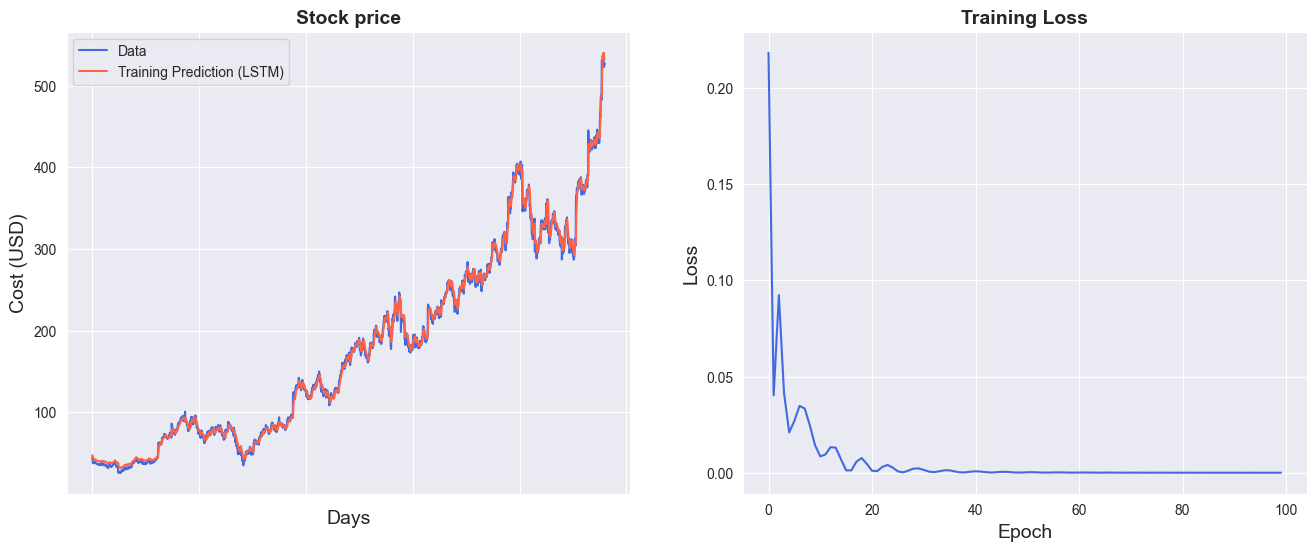

In [258]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


Make predictions on the testing set. Plot the training predictions through time (epochs).

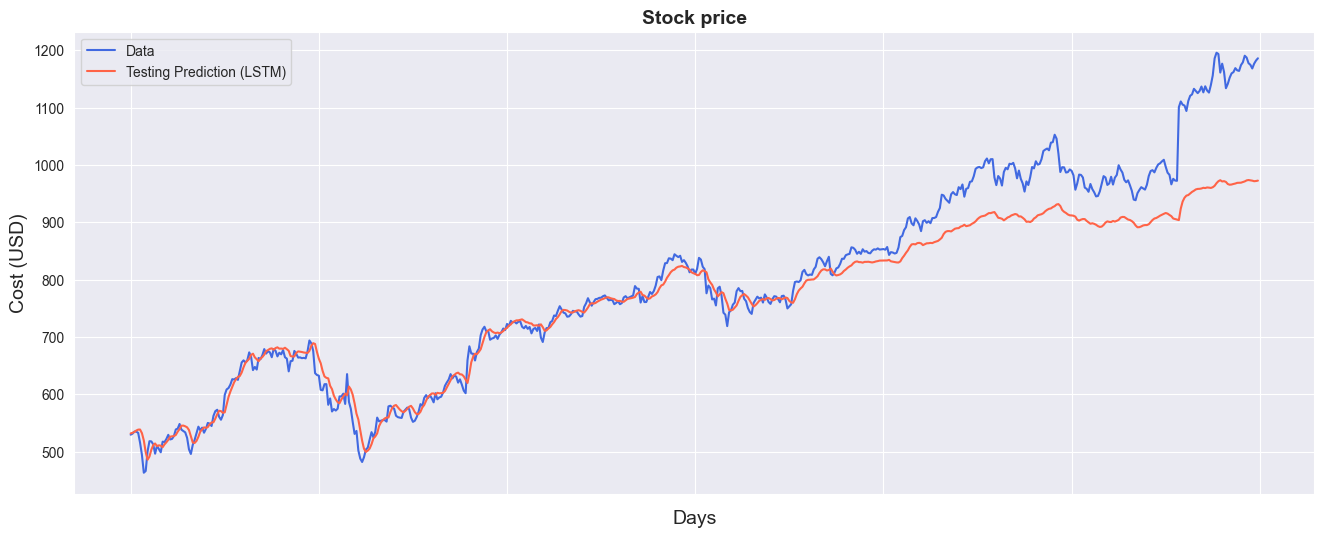

In [259]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device, torch.float32)
    y_test_pred = model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)


Calculate the MSE on both the training and testing data.

In [260]:
# calculate root mean squared error
y_train = y_train.detach().cpu().numpy()
y_train_pred = y_train_pred.detach().cpu().numpy()
trainScore = np.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test = y_test.detach().cpu().numpy()
y_test_pred = y_test_pred.detach().cpu().numpy()
testScore = np.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.01 RMSE
Test Score: 0.11 RMSE


## 5 - Built-in LSTM [10 points]

Use the provided code snippets and train a 1-layer LSTM network using the PyTorch built-in LSTM cell. Please show the prediction plots as well as the MSE on both training and testing data.

In [280]:
class MyLSTMNet(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, bias=True):
        super(MyLSTMNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Fill in the following 2 lines
        # Now using pytorch's nn.LSTM
        self.lstm_cell = nn.LSTM(input_dim, hidden_dim, num_layers, bias)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        device = x.device
        # Define the initial hidden and cell states
        ht = torch.zeros(x.shape[0], self.hidden_dim).to(device)
        ct = torch.zeros(x.shape[0], self.hidden_dim).to(device)
        
        # Use a for-loop to define the forward pass of the LSTM network

        for i in range(len(x[1])):
            x_input = x[:, i, :]
            output_gate, hidden_state, cell_state = self.lstm_cell(x_input, (ht, ct))
            ht = hidden_state
            ct = cell_state
        
        # Use the output embedding of the last timestep as the input to the linear layer

        # output = self.fc(output_gate)
        # I have been getting significantly better results with below
        output = self.fc(ht)
        
        return output

In [281]:
# remember to send the model's weights to the appropriate device (GPU or CPU)
new_model = MyLSTMNet(input_dim, hidden_dim, output_dim).to(device)

In [282]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device, torch.float32)
    y_train = y_train.to(device, torch.float32)
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

TypeError: LSTM.forward() got an unexpected keyword argument 'h_0'

## 6 - Built-in GRU [10 points]

Use the provided code snippets and train a 1-layer GRU network using the PyTorch built-in GRU cell. Please show the prediction plots as well as the MSE on both training and testing data.